In [40]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.widgets import CheckButtons, Slider
import numpy as np
from stoneforge.io.dlisio_r import inspect_dlis_structure, parse_dlis
import pandas as pd

info = inspect_dlis_structure("../stoneforge/datasets/DSDP_leg_96_hole_616_96_processed_data.dlis", verbose=False)
print(info)

{'LogicalFile(FDC/CNL/GR_main)': {'B59067': ['TDEP', 'RGR', 'RHGX', 'RHOB', 'RNFD', 'RNRA', 'TENS', 'TIME', 'GR', 'CALI', 'CS', 'DIFF', 'DPHI', 'DRHO', 'FCNL', 'FFDC', 'MARK', 'NCNL', 'NFDC', 'NPHI', 'NRAT', 'RCAL', 'RFFD']}, 'LogicalFile(FDC/CNL/GR_repeat)': {'B59180': ['TDEP', 'RGR', 'RHGX', 'RHOB', 'RNFD', 'RNRA', 'TENS', 'TIME', 'GR', 'CALI', 'CS', 'DIFF', 'DPHI', 'DRHO', 'FCNL', 'FFDC', 'MARK', 'NCNL', 'NFDC', 'NPHI', 'NRAT', 'RCAL', 'RFFD']}}


In [41]:
def _dict_to_dataframe(data):
    rows = []
    for digital_file, frames in data.items():
        for frame_name, mnemonics in frames.items():
            for mnemonic in mnemonics:
                rows.append([digital_file, frame_name, mnemonic])
    return pd.DataFrame(rows, columns=["Digital File", "Frame Name", "Mnemonics"])

def _dataframe_to_dict(df):
    data = {}
    for digital_file, frame_group in df.groupby("Digital File"):
        data[digital_file] = {}
        for frame_name, mnemonics_group in frame_group.groupby("Frame Name"):
            data[digital_file][frame_name] = mnemonics_group["Mnemonics"].tolist()
    return data

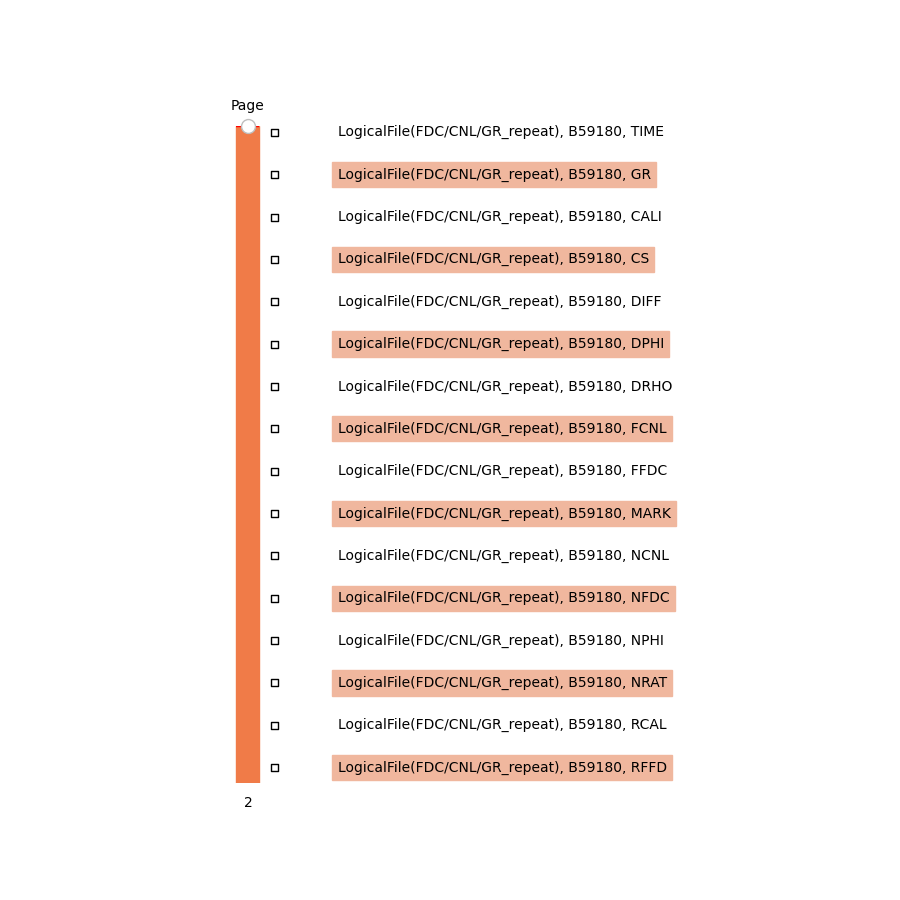

In [42]:
table = _dict_to_dataframe(info)

# Constants
ROWS_PER_PAGE = 30
LIGHT_COLOR = ("#f0b79e")  # Light blue shade for text background

# Calculate number of pages needed
total_rows = len(table)
num_pages = (total_rows + ROWS_PER_PAGE - 1) // ROWS_PER_PAGE  # Ceiling division

# Create figure with appropriate height
fig_height = max(6, min(ROWS_PER_PAGE, total_rows) * 0.3)
fig, ax = plt.subplots(figsize=(9, fig_height))  # Adjust size
plt.subplots_adjust(left=0.2)  # Make room for the vertical slider
ax.axis('off')

# Create vertical slider axis
slider_ax = plt.axes([0.25, 0.13, 0.05, 0.73])  # (left, bottom, width, height)
page_slider = Slider(slider_ax, 'Page', valmin = 1, valmax = num_pages, valinit=num_pages, valstep=1, orientation='vertical', color='#f07b48')

# Create checkbox axis (will be updated)
checkbox_ax = plt.axes([0.2, 0.1, 0.7, 0.8])  # (left, bottom, width, height)
checkbox_ax.set_axis_off()

# Store all checkbox states and labels globally
all_checkbox_states = [False] * total_rows
checkbox_labels_all = [', '.join(row) for row in table.values]
current_checkboxes = None

def update_checkboxes(page):
    global current_checkboxes
    
    # Clear previous checkboxes
    checkbox_ax.clear()
    checkbox_ax.set_axis_off()
    
    # Calculate current page range (reversed order)
    page_idx = int(num_pages - page)  # This reverses the page order
    start_idx = page_idx * ROWS_PER_PAGE
    end_idx = min(start_idx + ROWS_PER_PAGE, total_rows)
    
    # Get current page labels and states
    current_labels = checkbox_labels_all[start_idx:end_idx]
    current_states = all_checkbox_states[start_idx:end_idx]
    
    # Create new checkboxes
    current_checkboxes = CheckButtons(checkbox_ax, current_labels, current_states)
    
    # Apply alternating row colors
    for i, label in enumerate(current_checkboxes.labels):
        if i % 2 == 1:  # Apply light blue to every second row
            label.set_backgroundcolor(LIGHT_COLOR)
        else:
            label.set_backgroundcolor('white')  # Keep other rows white
        label.set_color('black')  # Set text color to black for contrast

    def toggle_row(label):
        global all_checkbox_states
        full_index = checkbox_labels_all.index(label)
        all_checkbox_states[full_index] = not all_checkbox_states[full_index]
        print(f'{label} is {"checked" if all_checkbox_states[full_index] else "unchecked"}')

    current_checkboxes.on_clicked(toggle_row)
    plt.draw()

# Initialize first page
update_checkboxes(1)

# Connect slider to update function
page_slider.on_changed(update_checkboxes)

plt.show()

In [12]:
selected_rows = [i for i, checked in enumerate(all_checkbox_states) if checked]
selected_table = table.iloc[selected_rows]
dict_data_info = _dataframe_to_dict(selected_table)
print(f"Selected {len(selected_table)} rows")
print("Selected rows data:")
print(dict_data_info)

Selected 5 rows
Selected rows data:
{'LogicalFile(FDC/CNL/GR_main)': {'B59067': ['TDEP', 'RHOB', 'GR', 'CALI', 'DRHO']}}


In [ ]:
"""
data_access = {
    'LogicalFile(RAB_shallow)':{
        'B77185':['TDEP','BSAV'],
        'B77226':['TDEP','RB','GR']
        },
    'LogicalFile(RAB_medium)':{
        'B77185':['TDEP','BMIM'],
        'B77226':['TDEP','GR']
        },
    'LogicalFile(RAB_deep)':{
        'B77226':['TDEP','GR'] 
        }
    }

data1 = parse_dlis("D:\dlis_samples\IODP_311-U1325A_rab-proc.dlis", data_access)
TDEP = data1['LogicalFile(RAB_shallow)']['B77185']['TDEP']['values']
TDEP_unit = data1['LogicalFile(RAB_shallow)']['B77185']['TDEP']['unit']
BSAV = data1['LogicalFile(RAB_shallow)']['B77185']['BSAV']['values']
BSAV_unit = data1['LogicalFile(RAB_shallow)']['B77185']['BSAV']['unit']
plt.plot(BSAV,TDEP)
plt.xlim(0.5,2.5)
plt.xlabel(BSAV_unit)
plt.ylabel(TDEP_unit)
plt.grid()
plt.show()
"""

In [ ]:
"""
data2 = parse_dlis("D:\dlis_samples\IODP_311-U1325A_rab-proc.dlis", data_access)
BMIM = data1['LogicalFile(RAB_medium)']['B77185']['BMIM']['values']
BMIM_unit = data1['LogicalFile(RAB_medium)']['B77185']['BMIM']['unit']

BMIM[BMIM <= -999.] = np.nan

plt.matshow(BMIM, interpolation='nearest', aspect='auto', vmin=0, vmax=3)
plt.show()
"""